In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits, normalize
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from scipy.special import logit
from DS_models_stat import stat_orig_cats
from DS_detector import rematch_cat
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from DS_models_stat import cut_cat

In [2]:
def m500_z_graph(cat_name, det_name, q_rat=0.1, big_pix=None, text='', max_pred_val=None):
    df = pd.read_csv(cat_name)
    df = df[df['status'] != 'fn']
    df.index = np.arange(len(df))
    
    true_cats = {'PSZ2(z)' : pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'),
                'MCXC' : pd.read_csv('/home/rt2122/Data/clusters/mcxcwp.csv'),
                'ACT' : pd.read_csv('/home/rt2122/Data/clusters/actwp.csv')
                #'MCXC' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/MCXC.csv'),
                #'ACT' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/ACT.csv')
                }
    
    if not (big_pix is None):
        df = cut_cat(df, big_pix=big_pix)
        for tr_cat in true_cats:
            true_cats[tr_cat] = cut_cat(true_cats[tr_cat], big_pix=big_pix)
        
    true_sc = {key : SkyCoord(ra=np.array(true_cats[key]['RA']) * u.degree, 
                              dec=np.array(true_cats[key]['DEC']) * u.degree, frame='icrs') for key in true_cats}
    
    q = df[df['catalog'] == 'planck_z']['max_pred'].quantile(q_rat)
    if not (max_pred_val is None):
        q = max_pred_val
    sc = SkyCoord(ra=np.array(df['RA']) * u.degree, dec=np.array(df['DEC']) * u.degree, frame='icrs')
    
    for name in true_cats:
        idx, d2d, _ = true_sc[name].match_to_catalog_sky(sc)
        true_cats[name]['max_pred'] = 0
        true_cats[name]['max_pred'] = np.array(df['max_pred'][idx])
        matched = d2d.degree < (400 / 3600)
        true_cats[name]['matched'] = matched
    
    fig, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
    fig.tight_layout()
    for i, (st, en) in enumerate([[q, 1], [0.1, 1]]):
        for name, c in zip(true_cats, ['b', 'r', 'c']):
            cur_cat = true_cats[name]
            cur_cat = cur_cat[cur_cat['matched']]
            match_max_pred = np.logical_and(st <= cur_cat['max_pred'], cur_cat['max_pred'] <= en)
            s = ax[i].scatter(cur_cat[match_max_pred]['z'], cur_cat[match_max_pred]['M500'], c=c, alpha=0.2)
            s.set_label('{} max_pred > {:.2g}'.format(name, st))
            plt.yscale('log')
    
    for name, c in zip(true_cats, ['b', 'r', 'c']):
        cur_cat = true_cats[name]
        cur_cat = cur_cat[np.logical_not(cur_cat['matched'])]
        s = ax[2].scatter(cur_cat['z'], cur_cat['M500'], c=c, alpha=0.2)
        s.set_label('{} unmatched'.format(name))
        plt.yscale('log')
    
    ax[0].set_ylabel('M500')
    for i in range(3):
        ax[i].set_ylim(10**-1, 20)
        ax[i].set_xlabel('z')
        ax[i].grid(which='minor', axis='both', linestyle='--')
        ax[i].grid(which='major', axis='both', linestyle='--')
        ax[i].legend()
    ax[1].set_title(text)


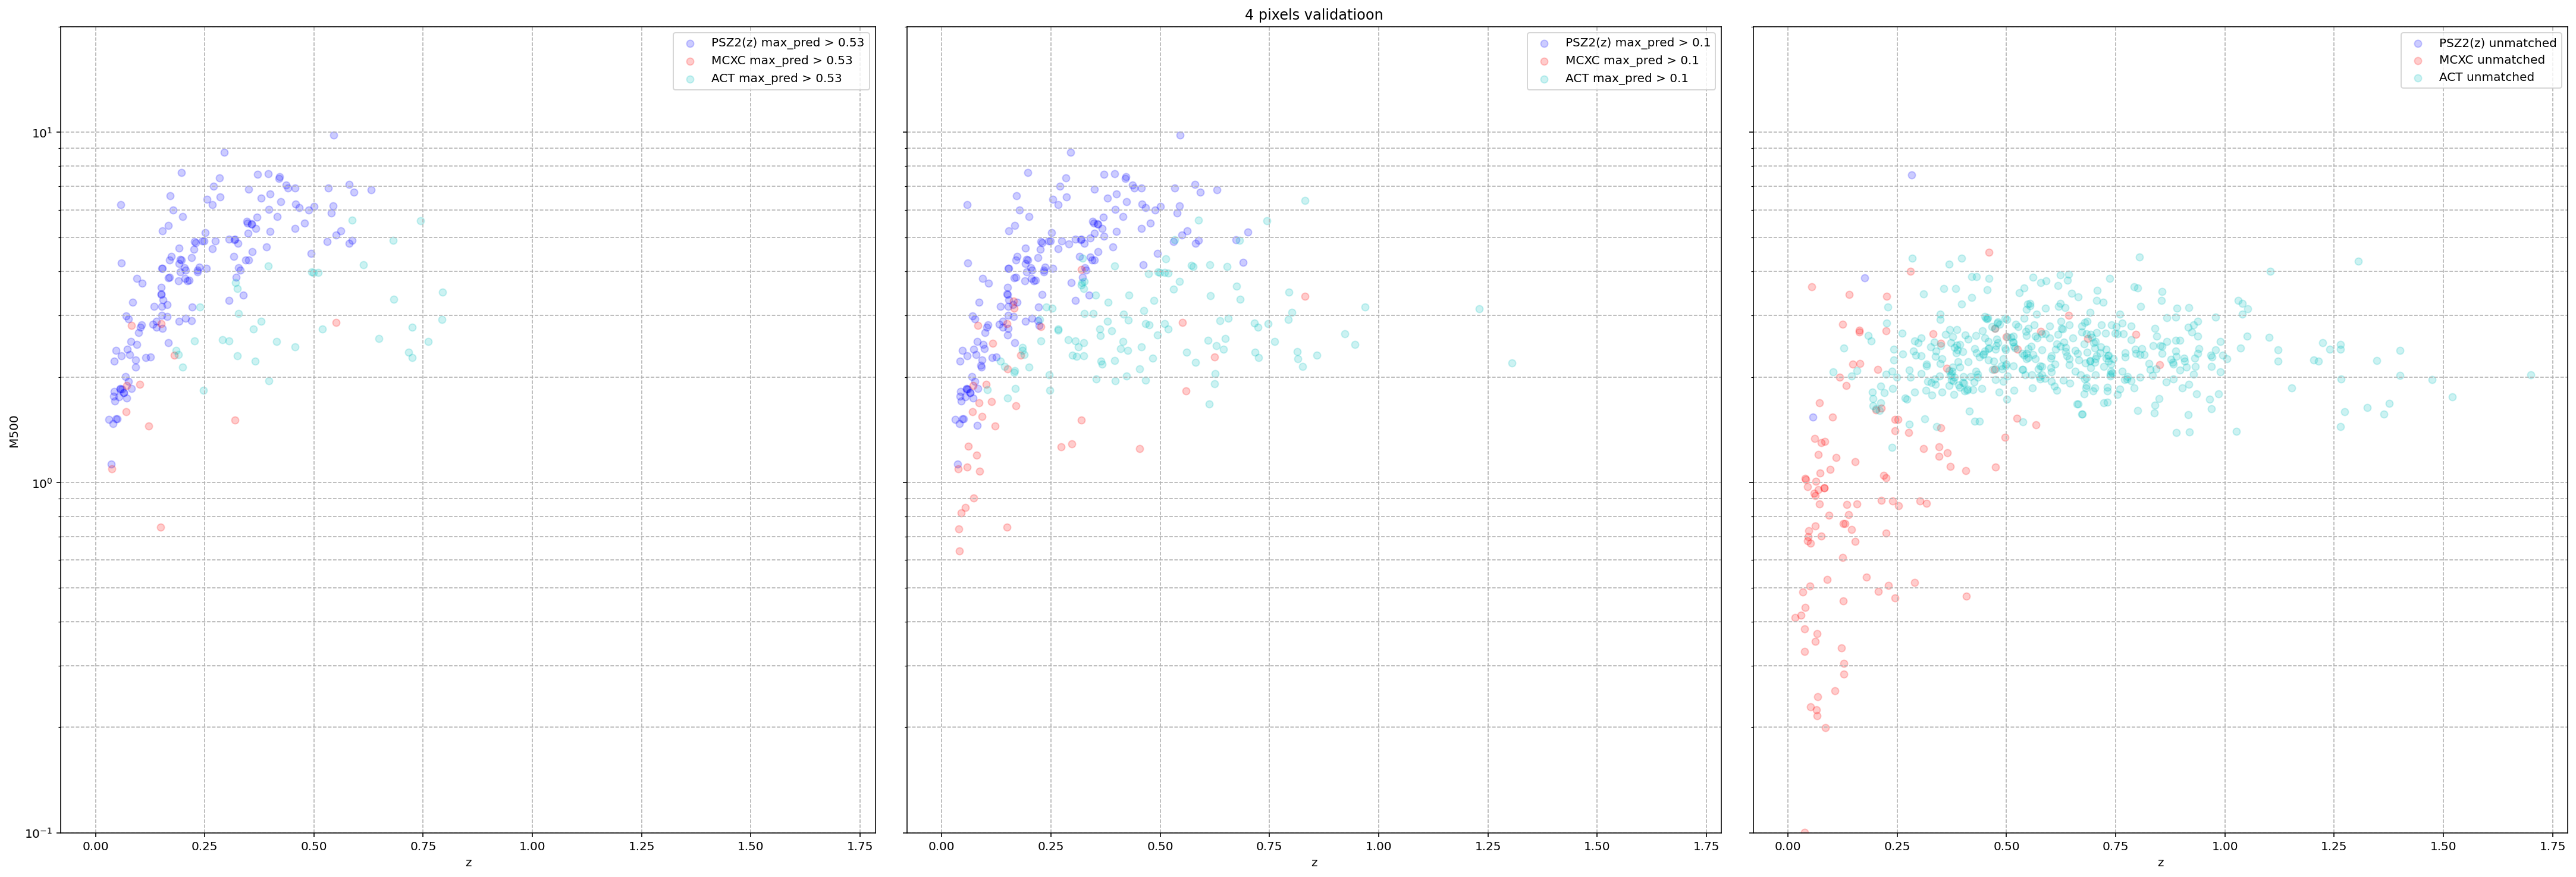

In [8]:
m500_z_graph('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', 'pz_all_found34', big_pix=west_val+east_val,
            text='4 pixels validatioon')

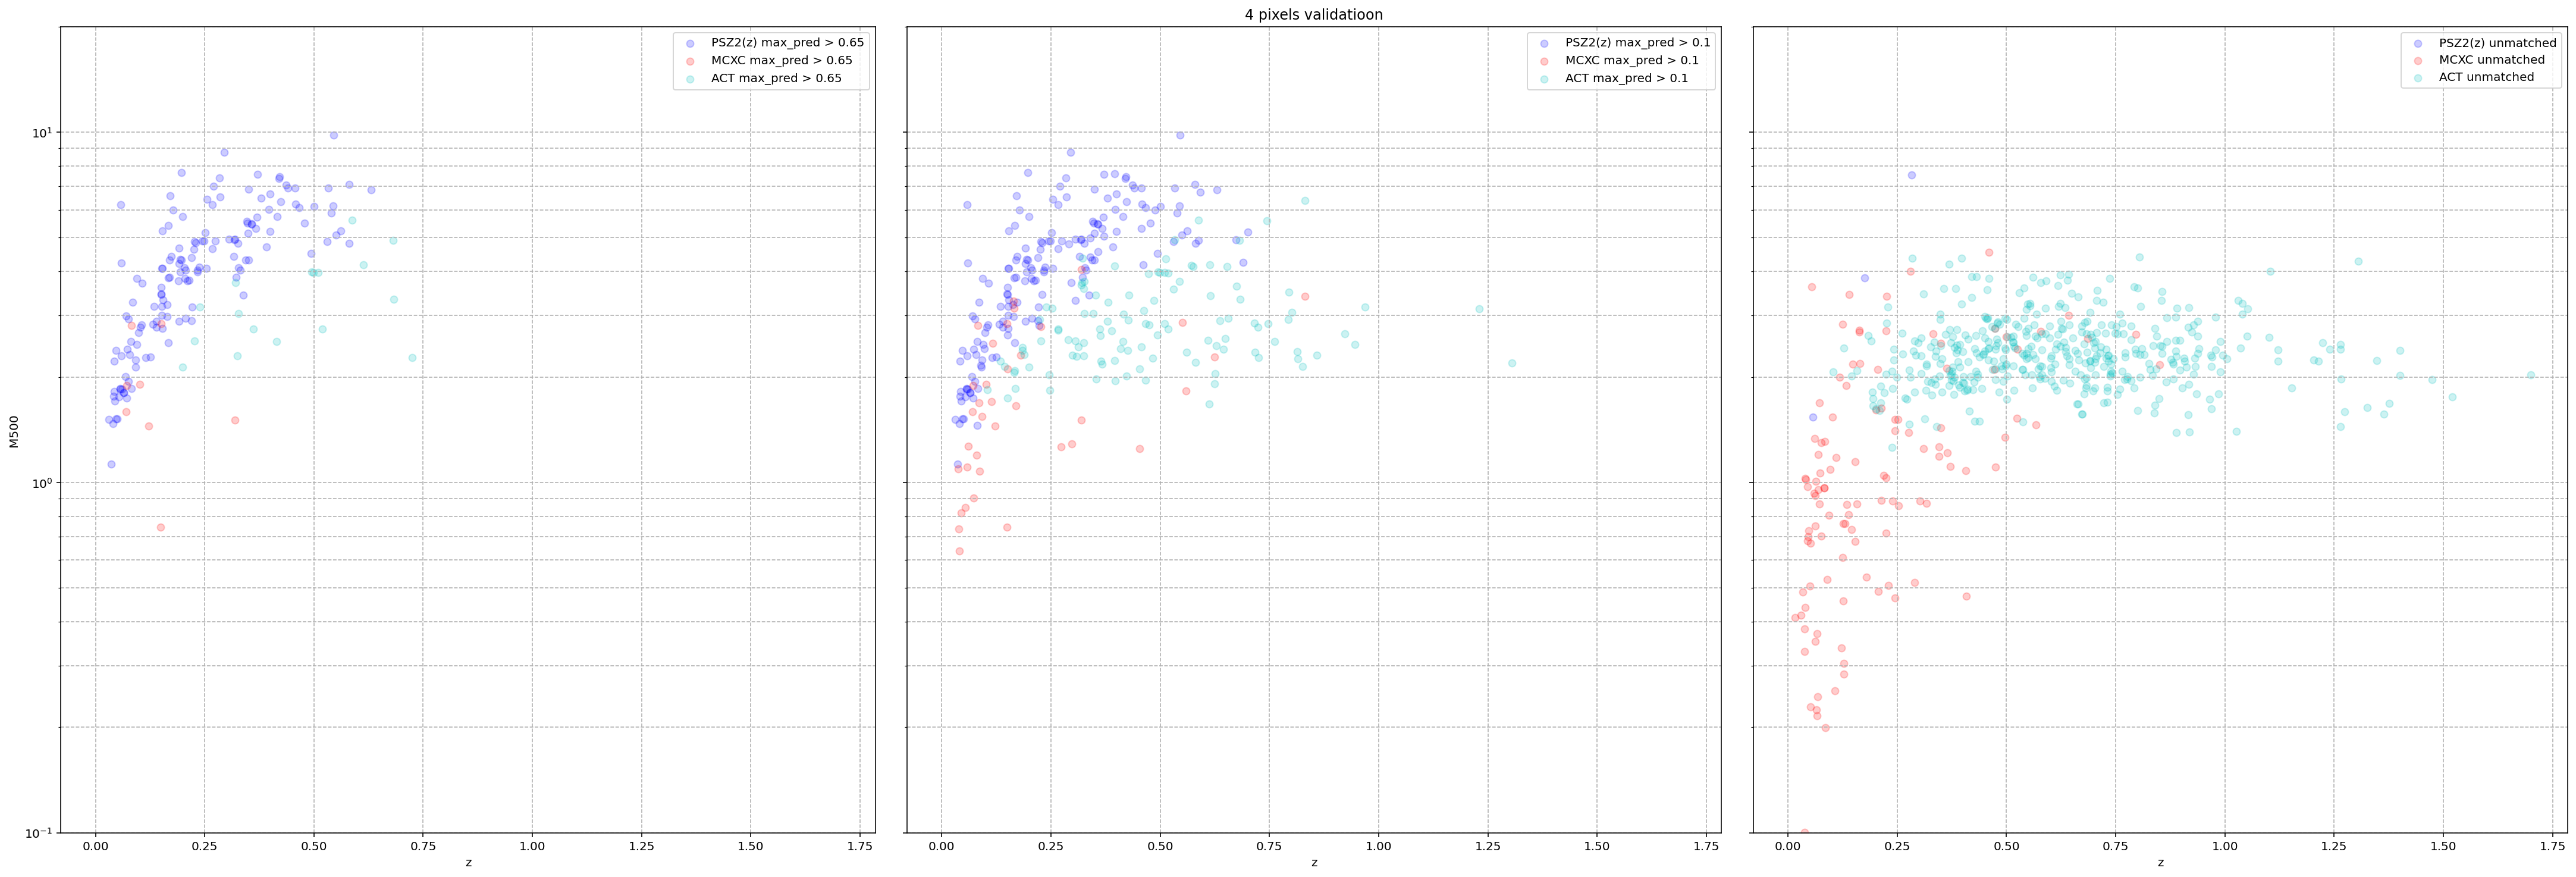

In [3]:
m500_z_graph('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', 'pz_all_found34', big_pix=west_val+east_val,
            text='4 pixels validatioon', max_pred_val=0.65)

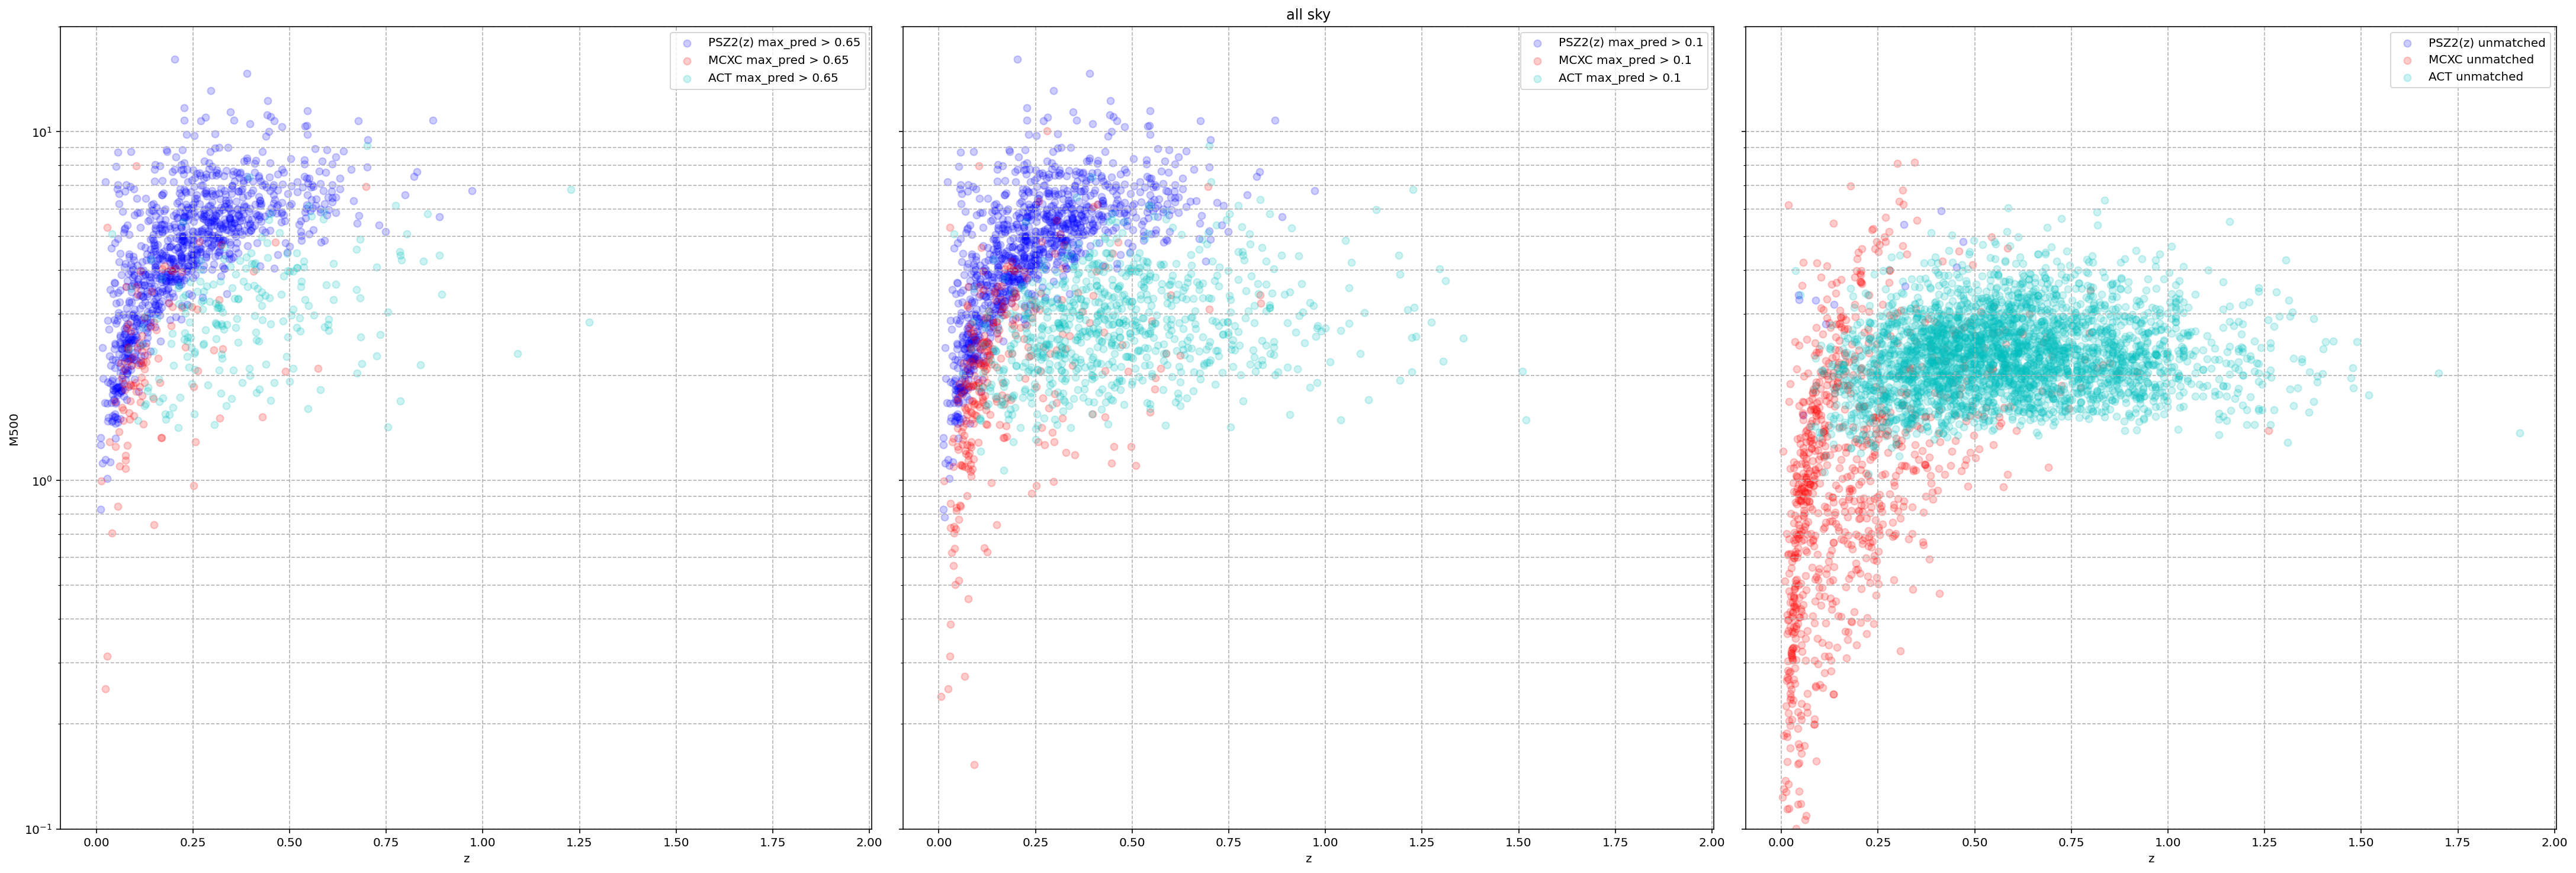

In [4]:
m500_z_graph('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', 'pz_all_found34', big_pix=list(range(48)),
            text='all sky', max_pred_val=0.65)